# Enclosed tessellation (proof of a concept)

This notebooks is a proof of a concept of enclosed tessellation, i.e. two-step partitioning of space based on building footprints and boundaries (e.g. street network, railway). 

## Load data


In [1]:
import os

import geopandas as gpd

from sqlalchemy import create_engine

user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(db_connection_url)

## Enclosed tessellation toy example

For the POC, we'll use road network as barriers and building footprints. Both now stored in PostGIS db.

In [2]:
x, y = 352125.32, 492802.86  # coordinates in epsg 27700
buffer = 5000  # radius in [m]

In [3]:
sql = f'SELECT * FROM openroads_200803_topological WHERE ST_Intersects(geometry, ST_Buffer(ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer}))'

roads = gpd.read_postgis(sql, engine, geom_col='geometry')

sql = f'SELECT * FROM openmap_buildings_200814 WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'

buildings = gpd.read_postgis(sql, engine, geom_col='geometry')

Enclosed tessellation is a `dask`-based parallelised algorithm, so let's start a client first.

In [4]:
from dask.distributed import Client

In [11]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35363 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 84.28 GB


`enclosed_tessellation` is loaded from `tessellation.py` in the same directory. 

In [6]:
from tessellation import enclosed_tessellation
from shapely.geometry import Point
import warnings

warnings.filterwarnings('always')

To specify an external limit of tesellation, we use the same limit we used for querying the data above.

In [12]:
# assign unique IDs
buildings['uID'] = range(len(buildings))

# get road-based polygons
limit = Point(x, y).buffer(buffer)

In [13]:
res = enclosed_tessellation(roads, buildings, limit, unique_id="uID")

<AxesSubplot:>

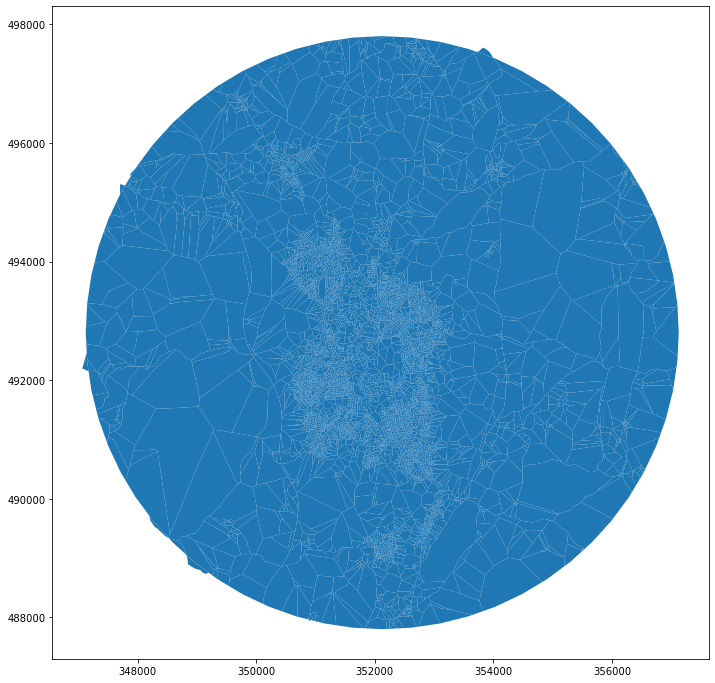

In [9]:
res.plot(figsize=(12, 12))

In [14]:
client.close()

## Real life example - Edinburgh MasterMap and OpenMap

In [15]:
mastermap = gpd.read_parquet('../../urbangrammar_samba/OS_MasterMap_Buildings_sample/edinburgh.pq')

In [16]:
from shapely.geometry import box
from shapely.wkb import dumps
bounds = mastermap.total_bounds
limit = box(*bounds)

In [17]:
sql = f"SELECT * FROM openroads_200803_topological WHERE ST_Intersects(geometry, ST_GeomFromText('{limit.wkt}',27700))"
roads = gpd.read_postgis(sql, engine, geom_col='geometry')

sql = f"SELECT * FROM openmap_buildings_200814 WHERE ST_DWithin(geometry, ST_GeomFromText('{limit.wkt}',27700), 0)"
openmap = gpd.read_postgis(sql, engine, geom_col='geometry')

/opt/conda/lib/python3.7/asyncio/base_events.py:626: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)


In [19]:
from shapely.ops import polygonize

polygons = polygonize(roads.geometry.append(gpd.GeoSeries([limit.boundary])).unary_union)
enclosures = gpd.array.from_shapely(list(polygons), crs=roads.crs)

### OpenMap

In [20]:
client = Client()

In [21]:
openmap['uID'] = range(len(openmap))
openmap_tess = enclosed_tessellation(roads, openmap, limit, unique_id="uID", enclosures=enclosures)

In [22]:
openmap_tess.to_parquet('../../urbangrammar_samba/OS_MasterMap_Buildings_sample/edinburgh_om_tess.pq')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


### MasterMap

Sometimes it is better to restart dask client to start with clean state.

In [23]:
client.restart()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


Client Scheduler: tcp://127.0.0.1:42561 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 84.28 GB


In [24]:
mastermap['uID'] = range(len(mastermap))
mastermap_tess = enclosed_tessellation(roads, mastermap, limit, unique_id="uID", enclosures=enclosures)

In [31]:
mastermap_tess.to_parquet('../../urbangrammar_samba/OS_MasterMap_Buildings_sample/edinburgh_mm_tess.pq')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


In [26]:
client.close()

In [29]:
mastermap.to_parquet('../../urbangrammar_samba/OS_MasterMap_Buildings_sample/edinburgh.pq')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.


In [30]:
openmap.to_parquet('../../urbangrammar_samba/OS_MasterMap_Buildings_sample/edinburgh_om.pq')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  """Entry point for launching an IPython kernel.
